In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [90]:
temperatures = pd.read_csv("FLOODS/datasets/Temperature_1901_2016_Pakistan.csv")

In [91]:
temps2017 = [10.50, 13.88, 18.37, 25.00, 29.25, 30.50, 30.31, 29.50, 27.12, 24.25, 16.88, 12.25]
temps2018 = [12.00, 14.81, 20.50, 25.25, 28.50, 31.38, 30.61, 30.02, 27.62, 22.60, 17.50, 12.275]
temps2021 = [10.72, 16.67, 21.48, 25.32, 29.23, 31.68, 31.49, 30.34, 29.39, 23.96, 18.06, 12.97]
temps2022 = [11.20, 15.04, 22.92, 28.36, 30.93, 31.33, 29.93, 28.66, 28.62, 24.18, 18.86, 13.7]
temps2023 = [9.98, 17.16]
manualYears = [2017,2018,2021,2022]
manualData = [temps2017, temps2018, temps2021, temps2022]
i = 0
k = 0
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for year in manualYears:
    for month in months:
        temperatures = temperatures.append({'Temperature - (Celsius)':manualData[i][k], ' Year':year, 'Month':month}, ignore_index=True)
        k += 1
    k = 0   
    i += 1
# yearlyTemps2017_2022 = [21.55, 21.87, 20.99, 20.81, 21.68, sum(temps2022)/12]
# temperatures

In [92]:
temperatures

,Temperature - (Celsius),Year,Month
0,7.72768,1901,January
1,8.93600,1901,February
2,16.96320,1901,March
3,21.27410,1901,April
4,26.04970,1901,May
...,...,...,...
1435,28.66000,2022,August
1436,28.62000,2022,September
1437,24.18000,2022,October
1438,18.86000,2022,November


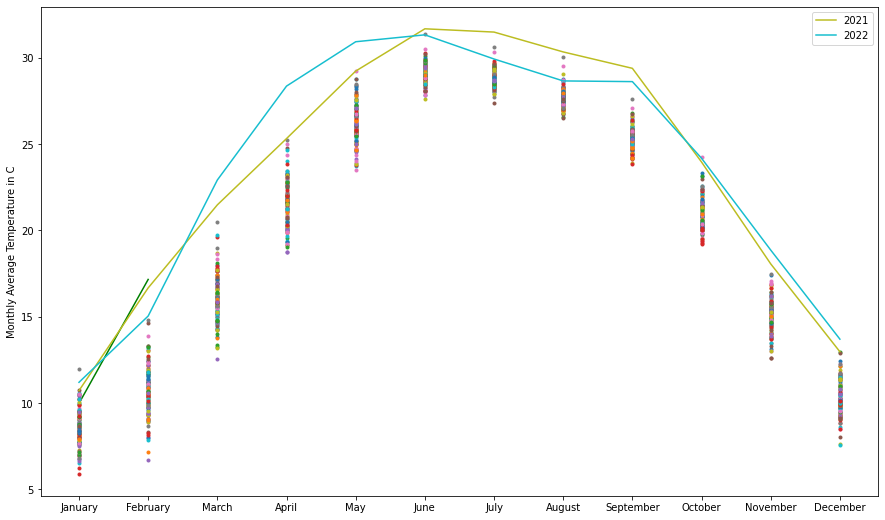

In [93]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(15,9))
plt.plot(months[:2], temps2023, '-', c='green')
for year in range(1901, 2023):
    if year in [2020, 2019]:
        continue
    if year in [2021, 2022]:
        plt.plot(months, temperatures[temperatures[" Year"] == year]["Temperature - (Celsius)"], '-', label=f'{year}')
        continue
    plt.plot(months, temperatures[temperatures[" Year"] == year]["Temperature - (Celsius)"], '.')
plt.legend()
plt.ylabel("Monthly Average Temperature in C")
plt.show()

In [94]:
temperatures.groupby([' Year'], axis=0, as_index=False).mean().corr()

,Year,Temperature - (Celsius)
Year,1.000000,0.565171
Temperature - (Celsius),0.565171,1.000000


In [95]:
meanAll = temperatures[(temperatures['Month'].isin(months)) & (temperatures[' Year'] != 2023)].groupby([' Year'], as_index=False).mean()['Temperature - (Celsius)']
meanAll

0      20.060848
1      20.406836
2      19.464821
3      19.970376
4      19.448188
         ...    
115    21.414617
116    22.317500
117    22.755417
118    23.442500
119    23.644167
Name: Temperature - (Celsius), Length: 120, dtype: float64

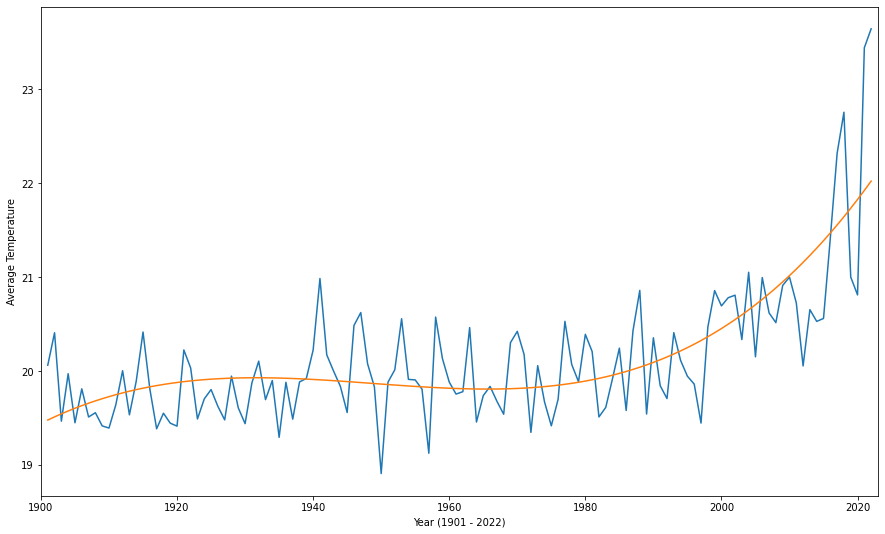

In [96]:
#fill missing data: 2019 2020 
meanAll2 = meanAll[:-2].tolist() + [21, 20.81] + meanAll[-2:].tolist()

plt.figure(figsize=(15,9))
plt.plot(list(range(1901,2023)), meanAll2)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pol = PolynomialFeatures(degree=5).fit_transform(np.array(list(range(1901,2023))).reshape(-1, 1))
model = LinearRegression()
model.fit(pol, meanAll2)
plt.plot(list(range(1901,2023)), model.predict(pol))# model.intercept_ + model.coef_ * np.array(list(range(1901,2017))))
plt.xlabel("Year (1901 - 2022)")
plt.ylabel("Average Temperature")
plt.xlim([1900, 2023])
plt.show()